##**Absa 50.02** Bert as Baseline model + Ctx-sentiment
Baseline model for absa annotated data sentiment classification
> Model used: (Pretrained) Bert For Sequence Classification('bert-base-chinese')

> Dataset: (4/1 updated) 

> Splitting: Training: 802 for training, 90 for validation and testing. 

> Model Performance:

[8/20]
Training acc:0.949, Training Loss: 0.137
Validation acc:0.922, Validation Loss: 0.337



##Data Extraction & Preprocessing

In [1]:
import pandas as pd
import csv

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
# filename = 'merged_frame_20210401.csv'
# df = pd.read_csv(filename)
# df = df[(df['from_name'].isin(['sentiment','ctx-sentiment']))]
# # df[df['A'].isin([3, 6])]
# df = df.dropna()
# df = df.reset_index()

In [4]:
# ratings = list(df['ent_choice'])
# new_ratings = []
# #  0:黃燈 1:綠燈 2:紅燈
# for rating in ratings:
#   rating = int(rating)
#   if rating > 3:
#     label = 1 # positive 
#   elif rating == 3:
#     label = 0 # neutral
#   else:
#     label = 2 # negative 
#   new_ratings.append(label)
# print(len(new_ratings))
# # a.to_frame().join(b)

In [5]:
# labels = pd.Series(new_ratings, name = 'labels')
# categories = df['from_name']
# data = df['ent_text']
# concat_df = data.to_frame().join(labels).join(categories)
# concat_df.to_csv('absa_annotsents_data_ctx.csv')
# df = concat_df
# df

In [6]:
# df['from_name'].value_counts()

## Loading data

In [7]:
import pandas as pd
import csv
from google.colab import drive
drive.mount('/content/drive') # Warrior29

Mounted at /content/drive


In [9]:
filepath = '//content/drive/MyDrive/指向情緒案/data/absa_bert_ctx_data.csv'
# df.to_csv(filepath, index = False)
df = pd.read_csv(filepath)

In [30]:
vc = df['from_name'].value_counts() 
# 
vc = list(vc)
print(f'Ctx sent ratio:{(vc[1]/sum(vc)):.3f}')

Ctx sent ratio:0.228


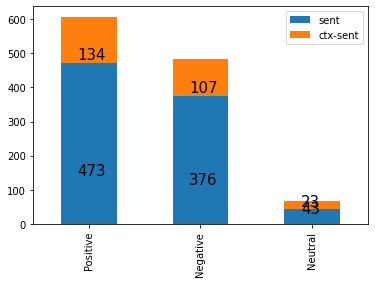

In [10]:
# Plotting
sent_df = df[df['from_name'] == 'sentiment']
ctx_sent_df = df[df['from_name'] == 'ctx-sentiment']
sent_count = pd.value_counts(sent_df['labels'])
ctx_sent_count =pd.value_counts(ctx_sent_df['labels'])
counts = pd.DataFrame({'sent': list(sent_count),
                   'ctx-sent': list(ctx_sent_count)})
fig = counts.plot.bar(stacked = True)
fig.set_xticklabels(['Positive', 'Negative', 'Neutral'])
sc = list(sent_count)
csc = list(ctx_sent_count)
# sum_counts = [x + y for x, y in zip(sc, csc)]
for i, (k,v) in enumerate(zip(csc, sc)):
    fig.text(i-0.1, v, str(k), fontsize= 15, va = 'bottom')
    fig.text(i-0.1, k, str(v), fontsize= 15, va = 'bottom')

## Preparing datasets & Loading pretrained Bert, tokenizer

In [ ]:
!pip install transformers

In [12]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification, BertConfig

device = torch.device("cuda")  
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', aux_logits = False)
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', output_hidden_states=True, num_labels = 3)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
from sklearn.model_selection import train_test_split
Max_len = 30
# df.info(verbose=True)
df['ent_text'] = df['ent_text'].apply(lambda x: x[:Max_len])
X = df['ent_text']
y = df['labels']

# Stratification 
# testing set is also used for validation due to the limit size of dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
print('Training data size:', len(X_train))
print('Testing data size:', len(X_test))
X_size = len(X_train)
y_size = len(X_test)

Training data size: 1040
Testing data size: 116


In [14]:
X_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = Max_len,
    padding=True,
    truncation=True
)
X_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = Max_len,
    padding=True,
    truncation=True
)

In [15]:
train_seq = torch.tensor(X_train['input_ids'])
train_mask = torch.tensor(X_train['attention_mask'])
train_y = torch.tensor(y_train.tolist(), dtype=torch.int64)

test_seq = torch.tensor(X_test['input_ids'])
test_mask = torch.tensor(X_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

In [16]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_y)
test_data = TensorDataset(test_seq, test_mask, test_y)
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


## Setting seed

In [17]:
# fix random seed for reproducibility
import os
import random
import tensorflow as tf
myseed = 43
os.environ['PYTHONHASHSEED'] = str(myseed)
np.random.seed(myseed)
random.seed(myseed) 
tf.random.set_seed(myseed)
torch.manual_seed(myseed)
# gpu 
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(myseed) 

## Training/Fine-tuning Bert
#### Source code reference:
https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

In [18]:
# Config
from transformers import AdamW
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
# put model (and batch) into device(device ='cuda' if gpu is available)
optimizer = AdamW(model.parameters(), lr = 1e-5, weight_decay = 0.05)
epochs = 20
loss_fn = nn.CrossEntropyLoss()
def cal_loss(pred, y): 
  '''L2 regularization'''
  # l2_lambda = 0.001
  # l2_reg = 0
  # for param in model.parameters():
  #   l2_reg += 0.5*(param**2).sum()
  # loss_fn = loss_fn(pred, y) + l2_lambda * l2_reg
  # return loss_fn
  return loss_fn(pred, y)

In [19]:
def train(dataloader = train_loader):
  model.train()
  losses, acc = 0, 0
  # iterate over batches
  for step, batch in enumerate(dataloader):
    # set to train mode
    model.train()
    batch = [r.to(device) for r in batch]
    sent_id, mask, label = batch

    # clear previously calculated gradients 
    model.zero_grad()        
    pred = model(sent_id, mask).logits

    _, pred2 = torch.max(pred, 1)
    loss = cal_loss(pred, label)
    loss.backward()
    acc += (pred2.cpu() == label.cpu()).sum().item()
    losses += loss.item()  
    
    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
  
  avg_acc = acc / X_size 
  avg_loss = losses / len(dataloader)

  return avg_loss, avg_acc

In [20]:
def validate(dataloader = test_loader):
  model.eval()
  val_losses, val_acc = 0, 0
  for step, batch in enumerate(dataloader):

    # push the batch to gpu
    batch = [t.to(device) for t in batch]
    sent_id, mask, label = batch

    with torch.no_grad():
      pred = model(sent_id, mask).logits
      loss = cal_loss(pred,label)
      _, pred2 = torch.max(pred, 1)
      val_acc += (pred2.cpu() == label.cpu()).sum().item()
      
      val_losses += loss.item()
  avg_acc = val_acc / y_size 
  avg_loss = val_losses / len(dataloader)
  
  return avg_loss, avg_acc

In [21]:
from os import path
# Saving checkpoint model
ckpt_path = '/content/drive/MyDrive/指向情緒案/50.02BERT_baseline_model/model.ckpt'
!mkdir -p /content/drive/MyDrive/指向情緒案/50.02BERT_baseline_model

In [22]:
import time
best_acc = 0.
loss_dict = {'train': [], 'val': []}
acc_dict = {'train': [], 'val': []}
start = time.time()
for epoch in range(epochs):
    print(f'[{epoch+1}/{epochs}]')
   
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    
    # append training and validation loss
    loss_dict['train'].append(train_loss)
    loss_dict['val'].append(val_loss)
    acc_dict['train'].append(train_acc)
    acc_dict['val'].append(val_acc)
    print(f'Training acc:{train_acc:.3f}, Training Loss: {train_loss:.3f}')
    print(f'Validation acc:{val_acc:.3f}, Validation Loss: {val_loss:.3f}')
    if val_acc > best_acc:
        best_acc = val_acc
        print(f'Saving model to {ckpt_path}.')
        torch.save(model.state_dict(), ckpt_path)
end = time.time()
print(f'Running {(end - start):.2f} seconds.')

[1/20]
Training acc:0.593, Training Loss: 0.866
Validation acc:0.776, Validation Loss: 0.681
Saving model to /content/drive/MyDrive/指向情緒案/50.02BERT_baseline_model/model.ckpt.
[2/20]
Training acc:0.838, Training Loss: 0.537
Validation acc:0.845, Validation Loss: 0.514
Saving model to /content/drive/MyDrive/指向情緒案/50.02BERT_baseline_model/model.ckpt.
[3/20]
Training acc:0.894, Training Loss: 0.376
Validation acc:0.853, Validation Loss: 0.466
Saving model to /content/drive/MyDrive/指向情緒案/50.02BERT_baseline_model/model.ckpt.
[4/20]
Training acc:0.920, Training Loss: 0.293
Validation acc:0.853, Validation Loss: 0.479
[5/20]
Training acc:0.924, Training Loss: 0.262
Validation acc:0.802, Validation Loss: 0.587
[6/20]
Training acc:0.929, Training Loss: 0.237
Validation acc:0.845, Validation Loss: 0.527
[7/20]
Training acc:0.935, Training Loss: 0.202
Validation acc:0.853, Validation Loss: 0.542
[8/20]
Training acc:0.943, Training Loss: 0.164
Validation acc:0.819, Validation Loss: 0.605
[9/20]
Tra

Utils' source code: by Heng-Jui Chang @ NTUEE in 2021 ML Spring 1.

In [23]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
def plot_learning_curve(record, title ='', is_loss = True):
    total_steps = len(record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(record['train']) // len(record['val'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, record['train'], c='tab:cyan', label='train')
    plt.plot(x_2, record['val'], c='tab:green', label='val')
    
    plt.xlabel('Training steps')
    if is_loss:
      plt.ylim(0.0, 5.)
      plt.ylabel('Cross Entropy Loss')
    else:
      plt.ylim(0.0, 1.)
      plt.ylabel('Accuracy')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

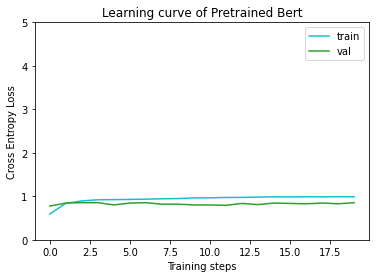

In [24]:
plot_learning_curve(acc_dict, title= 'Pretrained Bert', is_loss = True)

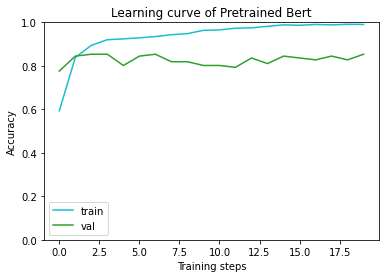

In [25]:
plot_learning_curve(acc_dict,  title= 'Pretrained Bert', is_loss = False)

## Loading model for testing 

In [26]:
model.load_state_dict(torch.load(ckpt_path))
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device)).logits
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.87      0.90      0.88        58
           2       0.84      0.92      0.88        51

    accuracy                           0.85       116
   macro avg       0.57      0.61      0.59       116
weighted avg       0.80      0.85      0.83       116

